#### Try to reproduce a MM valence force field from snapshots, energies, and forces

Without an attempt at pre-training to reproduce parameters first

In [1]:
import matplotlib.pyplot as plt
import torch
from openforcefield.topology import Molecule
from tqdm import tqdm

import torch
torch.set_default_dtype(torch.float64)

from espaloma.redux.energy import compute_valence_energy
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements
from torch.nn import functional as F

def initialize(hidden_dim=128, node_dim=128, activation=F.relu):
    
    node_representation = TAG(
        in_dim=len(elements),
        hidden_dim=hidden_dim,
        out_dim=node_dim,
        activation=activation
    )
    
    readouts = Readouts(
        atoms=MLP(node_dim, 2, activation),
        bonds=MLP(2 * node_dim, 2, activation),
        angles=MLP(3 * node_dim, 2, activation),
        propers=MLP(4 * node_dim, 6, activation),
        impropers=MLP(4 * node_dim, 6, activation)
    )
    
    valence_model = ValenceModel(node_representation, readouts)
    
    return valence_model

Using backend: pytorch


#### Fetch datasets

In [2]:
from glob import glob
path_to_dataset = '../../data/qca/*.h5'

paths_to_datasets = glob(path_to_dataset)
paths_to_datasets

['../../data/qca/eMolecules.h5',
 '../../data/qca/Roche.h5',
 '../../data/qca/Coverage.h5',
 '../../data/qca/Bayer.h5',
 '../../data/qca/Pfizer.h5']

In [3]:
import pandas as pd

##### Initially use just one of these datasets

In [4]:
df = pd.read_hdf('../../data/qca/Roche.h5')

#### Aggregate records by offmol



In [5]:
unique_offmols = list(set(df.offmol))
len(unique_offmols)

100

In [6]:
import numpy as np
xyzs = dict()
energies = dict()
gradients = dict()

energies_column = 'mm_energies_valence'
gradients_column = 'mm_gradients_valence'

for offmol in unique_offmols:
    mask = df.offmol == offmol
    xyzs[offmol] = torch.tensor(np.vstack(df.xyz[mask]))
    energies[offmol] = torch.tensor(np.hstack(df[energies_column][mask]))
    gradients[offmol] = torch.tensor(np.vstack(df[gradients_column][mask]))
    
    # check same number of total snapshots
    assert(xyzs[offmol].shape[0] == energies[offmol].shape[0])
    
    # check xyzs and gradients line up
    assert(xyzs[offmol].shape == gradients[offmol].shape)

### Fit a graph-net to energies and gradients

#### Initialize a basic valence-parameter-emitting graph net

In [7]:
from espaloma.graphs.utils import offmol_indices

valence_model = initialize()

#### Define functions for computing valence energies and gradients

In [8]:
def predict_energy_gradients(offmol, xyz, params):
    
    # make a copy of the coordinates that we'll take derivatives w.r.t.
    xyz = xyz.clone().detach().requires_grad_(True)
    
    pred_energies = compute_valence_energy(
        offmol=offmol,
        xyz=xyz,
        params=params,
    )
    
    # TODO: not sure if pytorch is smart enough to avoid blowing up memory when I call E.backward() after this stunt
    E = torch.sum(pred_energies)
    
    # Note: create_graph or retain_graph needed for higher-order derivatives
    E.backward(create_graph=True)
    
    return xyz.grad

In [9]:
for offmol in unique_offmols:
    _ = predict_energy_gradients(offmol, xyzs[offmol], valence_model.forward(offmol))

In [10]:
from espaloma.redux.transforms import perturb_from_null_params

In [11]:
def predict_perturbation_from_null_params(offmol, scaling=1e-3):
    return perturb_from_null_params(offmol, valence_model.forward(offmol), scaling)

In [12]:
def gradient_loss_on_mol(offmol, scaling=1e-3, batch_size=25):
    """MAE(g, g_ref)
    if batch_size=None, then use all available data
    """
    if type(batch_size) == int:
        inds = np.random.randint(0, len(xyzs[offmol]), batch_size)
    elif batch_size is None:
        inds = np.arange(len(xyzs[offmol]))
    else:
        raise(RuntimeError('unknown batch_size!'))
    
    params = predict_perturbation_from_null_params(offmol, scaling)
    g = predict_energy_gradients(offmol, xyzs[offmol][inds], params)
    g_ref = gradients[offmol][inds]
    
    return (torch.abs(g - g_ref)).mean()

In [13]:
gradient_loss_on_mol(offmol)

tensor(0.0047, grad_fn=<MeanBackward0>)

In [14]:
from espaloma.units import ENERGY_UNIT, FORCE_UNIT, DISTANCE_UNIT
from simtk import unit

report_energy_unit = unit.kilocalorie_per_mole
report_distance_unit = unit.angstrom
report_force_unit = report_energy_unit / report_distance_unit

In [15]:
def to_report_force_unit(f):
    return (f * FORCE_UNIT).value_in_unit(report_force_unit)

##### First, can we fit to a single molecule?

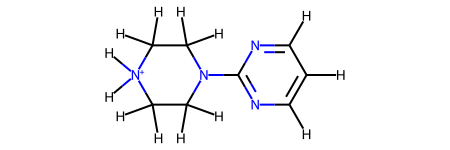

In [16]:
np.random.seed(0)
lucky_mol = np.random.choice(unique_offmols)
lucky_mol

In [17]:
len(xyzs[lucky_mol])

40

In [18]:
scaling = 1e-1
learning_rate = 1e-3
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    
    #lucky_mol = np.random.choice(unique_offmols)
    L = gradient_loss_on_mol(lucky_mol, scaling=scaling)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_loss_in_report_unit = to_report_force_unit(L.detach().numpy())
    
    batch_losses.append(batch_loss_in_report_unit)
    trange.set_postfix(batch_loss=batch_losses[-1])

100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s, batch_loss=1.12]


Text(0.5, 1.0, 'attempting to recover OpenFF 1.2 valence, with bad initialization')

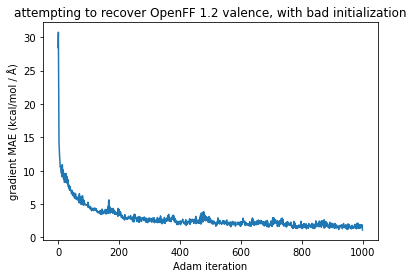

In [19]:
plt.plot(batch_losses)
plt.xlabel('Adam iteration')
plt.ylabel('gradient MAE (kcal/mol / Å)')
plt.title('attempting to recover OpenFF 1.2 valence, with bad initialization')

In [20]:
final_preds = dict()
for offmol in tqdm(unique_offmols):
    params = predict_perturbation_from_null_params(offmol, scaling)
    g = predict_energy_gradients(offmol, xyzs[offmol], params)
    final_preds[offmol] = g.detach()

100%|██████████| 100/100 [00:05<00:00, 19.99it/s]


Text(0.5, 1.0, 'attempting to recover OpenFF 1.2 valence, with bad initialization')

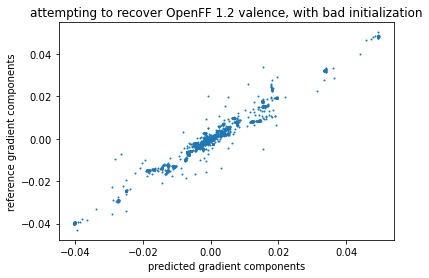

In [21]:
plt.scatter(final_preds[lucky_mol].flatten(), gradients[lucky_mol].flatten(), s=1)
plt.xlabel('predicted gradient components')
plt.ylabel('reference gradient components')
plt.title('attempting to recover OpenFF 1.2 valence, with bad initialization')

In [22]:
params = predict_perturbation_from_null_params(lucky_mol, scaling)

In [23]:
from espaloma.units import FORCE_CONSTANT_UNIT

(params.bonds[:,0] * FORCE_CONSTANT_UNIT).value_in_unit(report_energy_unit / report_distance_unit**2)

tensor([ 3.0870e+01,  3.0870e+01, -1.2854e+00,  3.0085e+01,  7.6547e+00,
         3.0085e+01,  7.6547e+00,  1.9422e+00,  1.9422e+00,  1.1875e+01,
         1.7881e+00,  1.7552e+00, -4.8186e-01, -4.8186e-01,  1.7881e+00,
         1.7552e+00, -4.8186e-01, -4.8186e-01,  7.0508e+01, -2.0786e-01,
        -2.0786e-01,  7.0508e+01, -2.0786e-01, -2.0786e-01, -2.9129e-02,
        -2.9129e-02], grad_fn=<MulBackward0>)

#### Observation: With bad initialization and without penalization, this occasionally predicts negative force constants!

### Question: Does this scheme work if we have "perfect" initialization (i.e. the graph net has to predict a perturbation of the reference parameters, and can get zero error if it predicts a perturbation of 0)?

#### First, do I have the reference parameters loaded properly?

In [24]:
from espaloma.redux.reference import get_ref_params

In [25]:
ref_params = get_ref_params(lucky_mol)

In [26]:
g_ref_prime = predict_energy_gradients(lucky_mol, xyzs[lucky_mol], ref_params)

In [27]:
g_ref = gradients[lucky_mol]

Text(0, 0.5, 'valence gradients predicted from reference parameters')

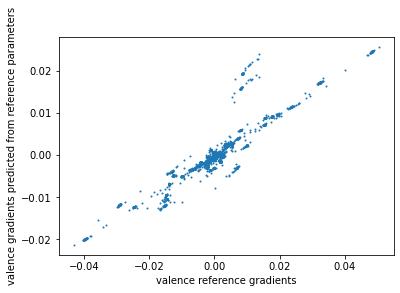

In [28]:
plt.scatter(g_ref.flatten(), g_ref_prime.detach().flatten(), s=1)
plt.xlabel('valence reference gradients')
plt.ylabel('valence gradients predicted from reference parameters')

##### Close, but not quite!

In [29]:
to_report_force_unit((g_ref.flatten() - g_ref_prime.detach().flatten()).abs().mean())

tensor(4.5547)

##### This either indicates an issue with the way I'm importing reference valence parameters, or with the way I'm computing energies from those parameters

##### Can I trace this down to impropers?

In [30]:
from espaloma.redux.symmetry import offmol_to_indices

In [31]:
# select a molecule that contains no impropers

offmols_with_no_impropers = []

for offmol in unique_offmols:
    if len(offmol_to_indices(offmol).impropers) ==  0:
        print(offmol)
        offmols_with_no_impropers.append(offmol)

Molecule with name '' and SMILES '[H]C1(C(C(O1)([H])[H])(C([H])([H])O[H])O[H])[H]'


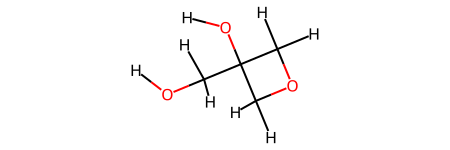

In [32]:
lucky_mol = offmols_with_no_impropers[0]
lucky_mol

In [35]:
ref_params = get_ref_params(lucky_mol)
g_ref_prime = predict_energy_gradients(lucky_mol, xyzs[lucky_mol], ref_params)
g_ref = gradients[lucky_mol]

Text(0, 0.5, 'valence gradients predicted from reference parameters')

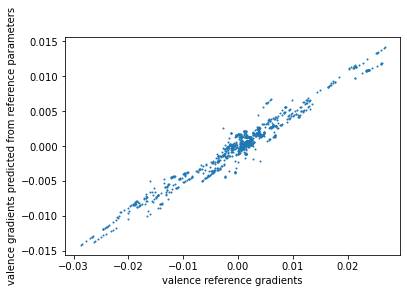

In [36]:
plt.scatter(g_ref.flatten(), g_ref_prime.detach().flatten(), s=1)
plt.xlabel('valence reference gradients')
plt.ylabel('valence gradients predicted from reference parameters')

##### Still not in perfect agreement even though there are no impropers...

In [33]:
valence_model = initialize()

In [34]:
scaling = 1e-1
learning_rate = 1e-3
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    
    #lucky_mol = np.random.choice(unique_offmols)
    L = gradient_loss_on_mol(lucky_mol, scaling=scaling)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_loss_in_report_unit = to_report_force_unit(L.detach().numpy())
    
    batch_losses.append(batch_loss_in_report_unit)
    trange.set_postfix(batch_loss=batch_losses[-1])

100%|██████████| 1000/1000 [00:44<00:00, 22.66it/s, batch_loss=2.08]


#### Second, can I predict a perturbation of these reference parameters that makes the loss small?